# 6. 텍스트와 시퀀스를 위한 딥러닝

텍스트(단어의 시퀀스 또는 문자의 시퀀스), 시계열 또는 일반적인 시퀀스
데이터를 <br>처리하는 기본적인 딥러닝 모델로는 순환 신경망(RNN)과 1D 컨브넷 두 가지가 있음

## 6.1 텍스트 데이터 다루기

### 6.1.1 단어와 문자의 원-핫 인코딩

### 코드 6-1 단어 수준의 원-핫 인코딩(간단 예)

In [39]:
import numpy as np

# 각 원소가 샘플, 여기서 샘플은 하나의 문장
samples = ['My dream is to contribute on world society', 'I want to need who be with me.']

# 데이터에 있는 모든 토큰의 인덱스를 구축
token_index = {}

for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

# 샘플을 벡터로 변환. 각 샘플에서 max_length까지 단어만 사용
max_length = 10
results = np.zeros(shape=(len(samples), max_length, max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    print ('\n')
    for j, word in list(enumerate(sample.split()))[:max_length]:        
        index = token_index.get(word)
        results[i, j, index] = 1.


### 코드 6-2 문자 수준 원-핫 인코딩(간단 예)

In [40]:
import string

samples = ['My dream is to contribute on world society', 'I want to need who be with me.']

# 출력 가능한 모든 ASCII 문자
characters = string.printable

# zip을 통해 동일한 개수로 characters를 묶고 dict로 변환
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.

### 코드 6-3 케라스를 사용한 단어 수준의 원-핫 인코딩

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer

samples = ['My dream is to contribute on world society', 'I want to need who be with me.']

# 가장 빈도가 높은 1,000개의 단어만 선택하도록 Tokenizer 객체를 만듦
tokenizer = Tokenizer(num_words=1000)

# 생성된 객체에 fit_on_texts 메서드를 사용하여 리스트를 입력으로 넣음
tokenizer.fit_on_texts(samples)

# 리스트를 입력으로 하여 텍스트를 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(samples)

# 텍스트를 행렬로 변환
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Unique Token : %s' % len(word_index))

Unique Token : 15


### 코드 6-4 해싱 기법을 사용한 수준의 원-핫 인코딩(간단 예)

In [47]:
samples = ['My dream is to contribute on world society', 'I want to need who be with me.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

### 코드 6-5 Embedding 층의 객체 생성

Embdding Layer는 크기가 (samples, seuqence_length)인 2D 정수 텐서를 입력으로 받음

In [49]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(1000, 64)

Embedding Layer는 크기가 (samples, sequence_length, embedding_dimensionality)인 3D 실수형 텐서 반환하며, <br>이런 3D 텐서는 RNN Layer나 1D 합성곱 Lyaer에서 처리됨

### 코드 6-6 Embedding Layer에 사용할 IMDB 데이터 로드

In [57]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# 특성으로 사용할 단어의 수 
max_features = 10000
maxlen = 20

# 정수 리스트로 데이터를 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

### 코드 6-7 IMDB 데이터에 Embedding 층과 분류기 사용

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()

# 나중에 임베딩된 입력을 Faltten Layer에서 펼치기 위해 Embedding 층에 input_length를 지정.
# Embedding Layer의 출력 크기는 (samples, maxlen, 8)이 됨
model.add(Embedding(10000, 8, input_length=maxlen))


# 3D 임베팅 텐서를 (samples, maxlen * 8) 크기의 2D 텐서로 펼침
model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, 
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6729 - acc: 0.6180 - val_loss: 0.6300 - val_acc: 0.6942
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5532 - acc: 0.7459 - val_loss: 0.5344 - val_acc: 0.7312
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4673 - acc: 0.7868 - val_loss: 0.5043 - va

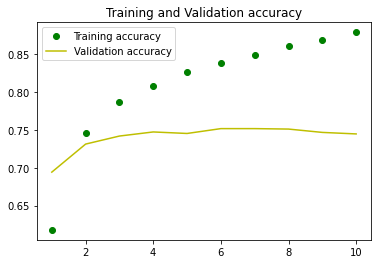

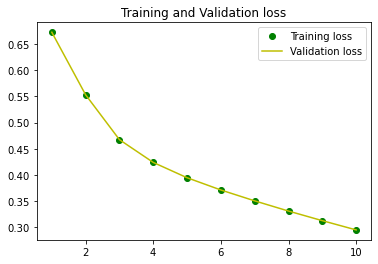

In [62]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['loss']

epoch = range(1, len(acc) +1 )

plt.plot(epoch, acc, 'go', label='Training accuracy')
plt.plot(epoch, val_acc, 'y', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epoch, loss, 'go', label='Training loss')
plt.plot(epoch, val_loss, 'y', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()